## Machine Learning Applications to the English Premier League

### _Introduction_
----------------------

The aim of this short project is to manage to predict the outcome of EPL matches with comparable accuracy to that of professional betting agencies. The target accuracy is around 53%. The structure of the notebook will be as follows: Firstly, the data are going to be imported and converted to a usable format making up the Data Import part of the Report. After that, the report will continue to the Data Tranformation and Exploartion Section. In this section the data will be coverted to dense information holding features and the redudant data will be discarded. The next section will describe the classificiers developed and how they perform. The report will then continue to a Model training and Evaluation Section will will describe how the classifiers were trained and then tested. Finally the Results Section will describe how well the model perfoms. In the end the final predictions of the test set will be given which will concluded the report.  


#### _Data Import_
------------------

This Section outlines how the data was imported to the notebook and how they were converted to a usable format. Firstly all data manipulation is made with the aid of **pandas**. Pandas allows for very easy imports as well as makes it able to process columns or rows of the datafiles very easily.



In [1]:
import pandas as pd

all_seasons = 'C://Users//nick//Desktop//ML_assignmen//epl-training.csv'
last_season = 'C://Users//nick//Desktop//ML_assignmen//E0.csv'


Source for last season files : http://www.football-data.co.uk/englandm.php.
These are the local paths to both files. 

In [2]:
df = pd.read_csv(all_seasons)
df.head()

,ID,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,1,13 Aug 05,Everton,Man United,0,2,A,0,1,A,...,5,5,15,14,8,6,3,1,0,0
1,2,13 Aug 05,Man City,West Brom,0,0,D,0,0,D,...,8,3,13,11,3,6,2,3,0,0
2,3,14 Aug 05,Arsenal,Newcastle,2,0,H,0,0,D,...,12,1,15,17,8,3,0,1,0,1
3,4,20 Aug 05,Newcastle,West Ham,0,0,D,0,0,D,...,6,1,9,11,10,2,1,1,0,1
4,5,21 Aug 05,Chelsea,Arsenal,1,0,H,0,0,D,...,6,3,17,21,3,7,2,3,0,0


This is the format of the first file listing a football match and features associated with it. As one can see pandas allows for efficient imports and data visualisation. The table like format allows for great visulation and the simple csv interface simplifies file reading a lot. 

In [3]:
last_season_df = pd.read_csv(last_season)
last_season_df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA,Unnamed: 65,Unnamed: 66,Unnamed: 67
0,E0,11/08/17,Arsenal,Leicester,4,3,H,2,2,D,...,1.91,1.85,2.10,2.02,1.49,4.73,7.25,NaN,NaN,NaN
1,E0,12/08/17,Brighton,Man City,0,2,A,0,0,D,...,1.95,1.91,2.01,1.96,11.75,6.15,1.29,NaN,NaN,NaN
2,E0,12/08/17,Chelsea,Burnley,2,3,A,0,3,A,...,2.03,1.97,1.95,1.90,1.33,5.40,12.25,NaN,NaN,NaN
3,E0,12/08/17,Crystal Palace,Huddersfield,0,3,A,0,2,A,...,2.10,2.05,1.86,1.83,1.79,3.56,5.51,NaN,NaN,NaN
4,E0,12/08/17,Everton,Stoke,1,0,H,1,0,H,...,1.94,1.90,2.01,1.98,1.82,3.49,5.42,NaN,NaN,NaN


The format here is a bit different but key features are present. 
>Note: The format of the date is different between the files

In [4]:
frames = [df,last_season_df]
df = pd.concat(frames)
df = df.reset_index(drop = True)

Here the dataframes are merged into one. The indexing is not consistent so the last line resets it. More information on dataframe merging: https://pandas.pydata.org/pandas-docs/stable/merging.html

In [5]:
from datetime import datetime
for row in df.itertuples(): 
    if row.Index < 1794: 
        df.set_value(row.Index , 'Date', datetime.strptime(row.Date, '%d %b %y'))
    else : 
        df.set_value(row.Index , 'Date', datetime.strptime(row.Date, '%d/%m/%y'))

The fact that the formats in date between the files are different does not allow for correct tranformation to datetime objects. For instance the line:
`df['Date'] = pd.to_datetime(df['Date'])` results in wrong ordering of the dates and even sorting them after with `df.sort_values(by = ['Date'])` corrects the problem. Therefore the conversion is done manually. This: https://docs.python.org/2/library/datetime.html helped in finding the correct formats since they differ from the usual datetime formats which can be seen here: https://docs.microsoft.com/en-us/dotnet/standard/base-types/standard-date-and-time-format-strings.

The data is now all imported and the two datasets merged in such a way that there are no errors in date ordering. This concludes the Data Import part of the report

#### _Data Tranformation and Exploration_

-------------------------------------------

This section essentially includes all processing made on the data before it is fed into the classifier. The first thing to do is to encode _FTR_, i.e. the Results of the matches, so that they take the form [0,0.5,1] instead of [H,D,A]. Furthermore, the team names should be encoded as well. 

In [6]:
def encode(df):
    unique_teams = list(df.HomeTeam.unique())
    for row in df.itertuples(): 
        if row.FTR == 'D': 
            df.set_value(row.Index , 'FTR', 0.5)
        elif row.FTR == 'H': 
            df.set_value(row.Index , 'FTR', 1)
        elif row.FTR == 'A':
            df.set_value(row.Index , 'FTR', 0)
        else: pass
        df.set_value(row.Index , 'HomeTeam' , unique_teams.index(row.HomeTeam))
        df.set_value(row.Index , 'AwayTeam' , unique_teams.index(row.AwayTeam))

    return df[['HomeTeam','AwayTeam','FTR','Date']] , unique_teams      

This is a brief function which takes the dataframe and encodes both the teams and the result in the format of an integer and a floating point number respectively. The function iterates through the rows of the dataframe and encodes the columns _FTR_, _HomeTeam_ and _AwayTeam_. The function also returns `unique_teams` a list with the unique teams throughout the league for later use. The function also returns only 4 columns of the data and discards the rest. This decision is made becuase these features seem to be enough to engineer crucial information.

In [7]:
df , unique_teams = encode(df)
df.head()

,HomeTeam,AwayTeam,FTR,Date
0,0,6,0,2005-08-13 00:00:00
1,1,9,0.5,2005-08-13 00:00:00
2,2,3,1,2005-08-14 00:00:00
3,3,8,0.5,2005-08-20 00:00:00
4,4,2,1,2005-08-21 00:00:00


As one can see the three first columns are all encoded. The date is kept to allow for creation of seasons in the later part of the file.

In [8]:
def create_seasons(df):
    season_number = 1
    previous_month = 8
    for row in df.itertuples(): 
        if row.Date.month - previous_month >= 2: 
            season_number += 1
        previous_month = row.Date.month
        df.set_value(row.Index,'Season_Number',season_number)
    return df

In [9]:
df = create_seasons(df)
df.tail()

,HomeTeam,AwayTeam,FTR,Date,Season_Number
2009,14,15,0,2018-01-02 00:00:00,13.0
2010,13,5,0,2018-01-02 00:00:00,13.0
2011,8,9,1,2018-01-02 00:00:00,13.0
2012,2,4,0.5,2018-01-03 00:00:00,13.0
2013,5,8,0.5,2018-01-04 00:00:00,13.0


The new column Season_Number is added here. It is needed for elo calculations which follow.

In [10]:
def find_previous_matches(index, home_team, away_team , df): 
    home_team_wins = 0
    away_team_wins = 0
    games_drawn = 0
    for row in df.itertuples(): 
        if row.Index < index and row.HomeTeam == home_team and row.AwayTeam == away_team: 
            if row.FTR == 1: 
                home_team_wins += 1
            elif row.FTR == 0.5: 
                games_drawn += 1
            else : 
                away_team_wins += 1
    return home_team_wins, away_team_wins, games_drawn

This function will locate all exact same matches played between two teams, home team and away team need to be same and not just the team names, and will return the outcomes of said matches.

In [11]:
def calculate_outcomes(home_team_wins, away_team_wins, games_drawn): 
    if home_team_wins + away_team_wins + games_drawn == 0: 
        return 0
    else : 
        return (home_team_wins - away_team_wins)/(home_team_wins + away_team_wins + games_drawn)

This function will return a float depicting the outcome of previous matches played by two teams. A values larger than zero shows that the home team won more games, a value of zero that the number of games won were the same for both teams and a values less than zero means the away team has won more of the previous games.

In [12]:
def weigh_previous_games(df):
    for row in df.itertuples(): 
        home_team_wins, away_team_wins , games_drawn = find_previous_matches(row.Index,row.HomeTeam, row.AwayTeam, df)
        df.set_value(row.Index , 'Previous_Outcomes', calculate_outcomes(home_team_wins, away_team_wins, games_drawn))
    return df                 

This function just combines two previous ones to generate the column Previous_Outcomes

In [13]:
df = weigh_previous_games(df)
df.tail()

,HomeTeam,AwayTeam,FTR,Date,Season_Number,Previous_Outcomes
2009,14,15,0,2018-01-02 00:00:00,13.0,1.000000
2010,13,5,0,2018-01-02 00:00:00,13.0,-0.666667
2011,8,9,1,2018-01-02 00:00:00,13.0,0.250000
2012,2,4,0.5,2018-01-03 00:00:00,13.0,-0.166667
2013,5,8,0.5,2018-01-04 00:00:00,13.0,0.545455


The above table shows the addition of the column Previous_Outcomes explained above

In [14]:
def find_two_previous_games(index,df,team):
    game_count = 0
    games_won = 0
    for row in df.itertuples(): 
        if row.Index < index and game_count < 3:
            if team == row.HomeTeam or team == row.AwayTeam:
                game_count += 1
                if team == row.HomeTeam and row.FTR == 1: 
                    games_won += 1
                elif team == row.AwayTeam and row.FTR == 0: 
                    games_won += 1
                else: 
                    pass
        else: 
            break
    if games_won == 2: 
        return 1
    else: return 0

This function finds the two previous games a team played and if they won both it determines the team to be on a streak.

In [15]:
def determine_team_streak(df):
    for row in df.itertuples(): 
        df.set_value(row.Index,'Home_Team_Streak',find_two_previous_games(row.Index,df,row.HomeTeam))
        df.set_value(row.Index,'Away_Team_Streak',find_two_previous_games(row.Index,df,row.AwayTeam))
    return df

This simple function just calls `find_two_previous_games` to avoid to many nested loops and creates columns to indicate whether the HomeTeam or AwayTeam is on Streak

In [16]:
df = determine_team_streak(df)
df.tail()

,HomeTeam,AwayTeam,FTR,Date,Season_Number,Previous_Outcomes,Home_Team_Streak,Away_Team_Streak
2009,14,15,0,2018-01-02 00:00:00,13.0,1.000000,0.0,0.0
2010,13,5,0,2018-01-02 00:00:00,13.0,-0.666667,0.0,0.0
2011,8,9,1,2018-01-02 00:00:00,13.0,0.250000,0.0,0.0
2012,2,4,0.5,2018-01-03 00:00:00,13.0,-0.166667,1.0,0.0
2013,5,8,0.5,2018-01-04 00:00:00,13.0,0.545455,0.0,0.0


The table is used to show the two new columns.

In [17]:
def create_elo_system(df,unique_teams):
    elo_dictionary = dict((team,0) for team in unique_teams)
    current_season = 1
    for row in df.itertuples():
        if row.Season_Number != current_season: 
            elo_dictionary = dict((team,0) for team in unique_teams)
            current_season = row.Season_Number
        if row.FTR == 1: 
            df.set_value(row.Index,'Home_Team_ELO',elo_dictionary[unique_teams[row.HomeTeam]])
            df.set_value(row.Index,'Away_Team_ELO',elo_dictionary[unique_teams[row.AwayTeam]])
            elo_dictionary[unique_teams[row.HomeTeam]] += 3
        elif row.FTR == 0.5:
            df.set_value(row.Index,'Home_Team_ELO',elo_dictionary[unique_teams[row.HomeTeam]])
            df.set_value(row.Index,'Away_Team_ELO',elo_dictionary[unique_teams[row.AwayTeam]])
            elo_dictionary[unique_teams[row.HomeTeam]] += 1
            elo_dictionary[unique_teams[row.AwayTeam]] += 1
        else: 
            df.set_value(row.Index,'Home_Team_ELO',elo_dictionary[unique_teams[row.HomeTeam]])
            df.set_value(row.Index,'Away_Team_ELO',elo_dictionary[unique_teams[row.AwayTeam]])
            elo_dictionary[unique_teams[row.AwayTeam]] += 3
    return df,elo_dictionary
        

This function implements the Premier League ELO System. The function causes a reset every time a new season starts and distributes points in line with the Premier League's System.

In [18]:
df,elo_dictionary = create_elo_system(df,unique_teams)
df.tail()

,HomeTeam,AwayTeam,FTR,Date,Season_Number,Previous_Outcomes,Home_Team_Streak,Away_Team_Streak,Home_Team_ELO,Away_Team_ELO
2009,14,15,0,2018-01-02 00:00:00,13.0,1.000000,0.0,0.0,20.0,19.0
2010,13,5,0,2018-01-02 00:00:00,13.0,-0.666667,0.0,0.0,16.0,37.0
2011,8,9,1,2018-01-02 00:00:00,13.0,0.250000,0.0,0.0,18.0,16.0
2012,2,4,0.5,2018-01-03 00:00:00,13.0,-0.166667,1.0,0.0,38.0,45.0
2013,5,8,0.5,2018-01-04 00:00:00,13.0,0.545455,0.0,0.0,40.0,21.0


The addition of the last two columns Home_Team_ELO and Away_Team_ELO can be seen in the table above.

In [19]:
df.to_csv('C://Users//nick//Desktop//ML_assignmen//dataframe.csv')

Here I exported the dataframe to check everything was in order. 

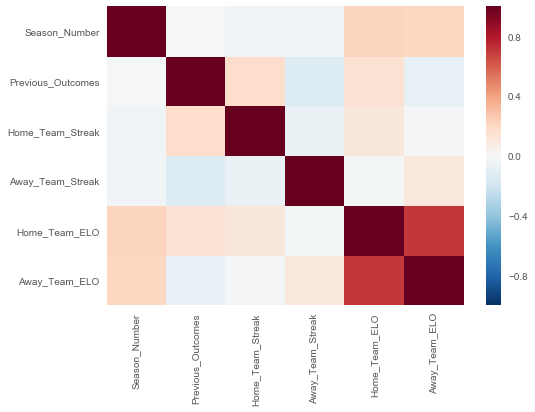

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
sns.heatmap(df.corr())
plt.show()

Tha above heatmap shows the pearson correlation between the different features. This is done to determine if there is a perfect corellation between two different variables. If there were that would render them redundant since the offer no adittional information. However, the only perfect unison corellations are in the diagonal, i.e. a feature with itself. The strongest corellation is between Home and Away Team ELO but that is not that strong to signal that one of them should not be considered information carrying. 

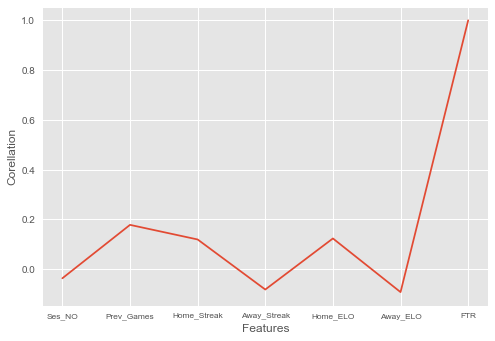

In [21]:
df['FTR_encoded'] = df['FTR'].astype('category')
df['FTR_encoded'] = df['FTR_encoded'].cat.codes
columns_array = ['Ses_NO','Prev_Games','Home_Streak','Away_Streak','Home_ELO','Away_ELO','FTR']
corellations = df[df.columns].corr()['FTR_encoded']
plt.plot(range(0,len(columns_array)),corellations)
plt.xlabel('Features')
plt.ylabel('Corellation')
plt.xticks(range(0,len(columns_array)), columns_array, size = 'small')
plt.show()


The relationship between FTR and the features is also very interesting. As one can see the features to be used have stronger corellations to FTR than those which will not be used. For example Previous outcomes is more strongly corellated to FTR than Season Number which has almost zero corellation as expected.

This concluded the dimensionality reduction since both feature selection and extraction have taken place to arrive a key set of 5 features which all have a strong corellation coefficient to FTR.

#### _Methodology_

--------------------

This section will include all steps taken so far and will detail the classifiers to be used in tackling the problem. The processing started with two raw data files which included a large number of features for each match. From those features only four were kept. That is the result of the match the home and away team and the date. The date is was not used in feature creation, but it was just for validating that the data did not get mixed up. The result, home team and away team were all encoded. Following that, seasons were created so as to allow ELO reset in the beginning of each season. The features created were: 
1. Home and Away Team Streaks: This Feature depicts whether each of the teams has won both their previous matches. It has binary form, that is can be either 1 indicating the team is on Streak or 0 indicating it is not. 
2. Home and Away Team ELO: The ELO for each datapoint is that of the teams before the game, since we cannot use the elo after the game to predict the outcome of the game. The ELO is calculated with the standard EPL system, i.e. 3 points for a win, 1 for a draw and 0 for a loss. 
3. Previous_Outcomes: This feature calculates a floating-point number depicting how all the previous matches between the teams have played out.

The data is now ready to be fit with a classifier. The data is not enough in number to suggest a neural-network architechture is optimal. However, it could be that a neural network actually has success in such a dataset. The suggested algorithms for such tasks involve logistic regression and support vector machines. The Neural Network Architechture will also be explored using a small neural network will no external libraries. The methods are implimented here and compared with one another. The multivariant version of both of these normally binary algorithms is used, since the target can take one of three values. 

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
import random
import numpy as np

def apply_classifier(df, model= None, cross_validation = False, print_test=False):
    train_data , test_data = train_test_split(df,test_size = 0.2,shuffle = False)
    train_data = shuffle(train_data)
    test_data = shuffle(test_data)
    train_X = train_data[['Home_Team_ELO','Away_Team_ELO','Previous_Outcomes','Home_Team_Streak','Away_Team_Streak']]
    train_Y = train_data[['FTR']]
    for row in train_Y.itertuples(): 
        if row.FTR == 0.5: 
            train_Y.set_value(row.Index,'FTR',2)
    train_Y = train_Y.astype(int)
    test_X = test_data[['Home_Team_ELO','Away_Team_ELO','Previous_Outcomes','Home_Team_Streak','Away_Team_Streak']]
    test_Y = test_data[['FTR']]
    for row in test_Y.itertuples(): 
        if row.FTR == 0.5: 
            test_Y.set_value(row.Index,'FTR',2)
    test_Y = test_Y.astype(int)
    if model == 'SVM': 
        clf = SVC()
        if print_test: 
            clf.fit(train_X,train_Y.values.ravel())
            i = 0
            for row in test_X.itertuples(): 
                data = np.array(row[1::]).reshape(1,-1)
                print('Target:' , test_Y.values[i], 'Prediction:', clf.predict(data))
                i+= 1
        else:
            if cross_validation == True:
                accuracy_values = cross_val_score(clf,train_X,train_Y.values.ravel(),cv=10)
                iterations = range(0,len(accuracy_values))
                plt.plot(iterations,accuracy_values)
                plt.xlabel('Cross_Validation_Iterations')
                plt.ylabel('Accuracy')
                plt.show()
                print('Mean Accuracy:' , accuracy_values.mean(),'%')
            else:
                clf.fit(train_X,train_Y.values.ravel())
                print('Accuracy:', clf.score(test_X,test_Y),'%')
        return clf
    
    elif model == 'Logistic_Regression':
        logreg = LogisticRegression(C=1,solver='lbfgs',class_weight = 'balanced')
        if print_test: 
            logreg.fit(train_X,train_Y.values.ravel())
            i = 0
            for row in test_X.itertuples(): 
                data = np.array(row[1::]).reshape(1,-1)
                print('Target:' , test_Y.values[i], 'Prediction:', logreg.predict(data))
                i+= 1
        else:
            if cross_validation:
                accuracy_values = cross_val_score(logreg,train_X,train_Y.values.ravel(),cv=10)
                iterations = range(0,len(accuracy_values))
                plt.plot(iterations,accuracy_values)
                plt.xlabel('Cross_Validation_Iterations')
                plt.ylabel('Accuracy')
                plt.show()
                print('Mean Accuracy:' , accuracy_values.mean(),'%')
            else:
                logreg.fit(train_X,train_Y.values.ravel())
                print('Accuracy:', logreg.score(test_X,test_Y),'%')
        return logreg 

This function implements the actual classification. The train and test sets are created. The data is not shuffled here becuase the first data points have inaccurate ELO values and therefore we should not use them for accuracy testing. The data is shuffled after the train and test plit. Two classifiers are used, that is Logistic Regression and a Support Vector Machine.
After training both classifiers they output the accuracy of the model, determined by prediction of the test set. The training process for both algorithms involves decleration of the classifiers using _sklearn_ then fiting the data and finally getting the accuracy of the model using the _score_ attribute of both classifier objects.  

In [23]:
logreg = apply_classifier(df,model = 'Logistic_Regression')

Accuracy: 0.506203473945 %


In [24]:
logreg = apply_classifier(df,model = 'Logistic_Regression',print_test=True)

Target: [1] Prediction: [1]
Target: [1] Prediction: [1]
Target: [1] Prediction: [0]
Target: [0] Prediction: [0]
Target: [0] Prediction: [0]
Target: [1] Prediction: [0]
Target: [1] Prediction: [0]
Target: [1] Prediction: [1]
Target: [1] Prediction: [0]
Target: [2] Prediction: [1]
Target: [2] Prediction: [0]
Target: [1] Prediction: [1]
Target: [0] Prediction: [1]
Target: [1] Prediction: [1]
Target: [0] Prediction: [0]
Target: [0] Prediction: [0]
Target: [0] Prediction: [1]
Target: [1] Prediction: [1]
Target: [1] Prediction: [1]
Target: [1] Prediction: [2]
Target: [0] Prediction: [2]
Target: [1] Prediction: [1]
Target: [1] Prediction: [2]
Target: [2] Prediction: [1]
Target: [2] Prediction: [1]
Target: [2] Prediction: [0]
Target: [0] Prediction: [0]
Target: [1] Prediction: [1]
Target: [1] Prediction: [1]
Target: [2] Prediction: [0]
Target: [2] Prediction: [2]
Target: [0] Prediction: [0]
Target: [0] Prediction: [1]
Target: [0] Prediction: [0]
Target: [0] Prediction: [1]
Target: [2] Predicti

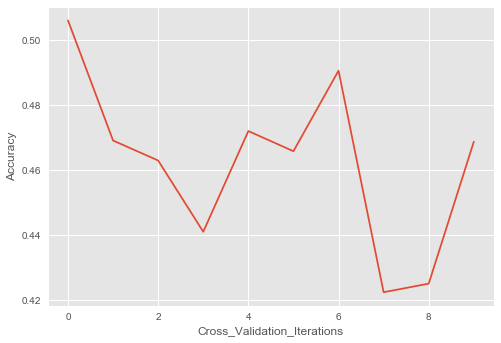

Mean Accuracy: 0.462394707078 %


LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [25]:
apply_classifier(df,model = 'Logistic_Regression', cross_validation = True)

In [26]:
apply_classifier(df,model = 'SVM')

Accuracy: 0.473945409429 %


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

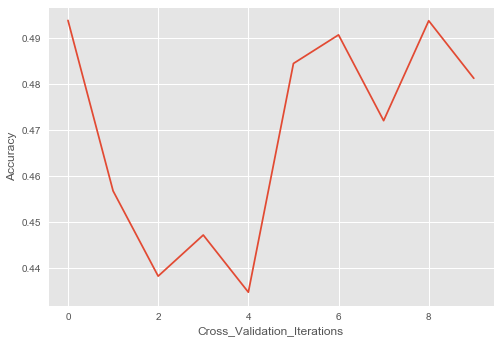

Mean Accuracy: 0.469308143547 %


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [27]:
apply_classifier(df,model = 'SVM',cross_validation=True)

Logistic Regression seems to have a higher accuracy than Support Vector Machines in this case. The accuracy obtained is comparable to that of bibliography without complicating the feature selection and processing to much. Furthermore, it seems that the process of cross validation lowers the accuracy but it does allow for better insight in the training process.

In [28]:
def sigmoid(x , deriv = False): 
    result = 1/(1+np.exp(-x))
    if deriv: 
        return result*(1-result)
    return result

def softmax(x): 
    exp = np.exp(x)
    return exp/np.sum(exp , axis = 0)

def cost(x, y, deriv = True):
    return x - y

def train_model(X , y , input_nodes , hl_nodes ,  output_nodes , iterations , a = 0.001):

    ''' ----------------------------- Initialization ------------------- '''

    np.random.seed(3)
    W1 = np.random.randn(input_nodes , hl_nodes)
    b1 = np.zeros(hl_nodes)
    W2 = np.random.randn(hl_nodes , output_nodes)
    b2 = np.zeros(output_nodes)

    for i in range(0,iterations):
        if i%40 == 0:
            print('Progress:' , 100*i/iterations, '%')
        

        ''' ------------------------ Feedforward ------------------------ '''

        z1 = X.dot(W1) + b1
        a1 = sigmoid(z1)
        z2 = a1.dot(W2) + b2
        a2 = sigmoid(z2)

        ''' ----------------------- Backpropagation ---------------------- '''

        delta = cost(a2, y)
        delta2 = np.multiply(np.dot(delta , W2.T) , sigmoid(z1, deriv = True))
        db2 = np.sum(delta , axis = 0)
        dW2 = np.dot(a1.T , delta)
        db1 = np.sum(delta2 , axis = 0)
        dW1 = np.dot(X.T , delta2)

        ''' ---------------------- Update -------------------------------- '''
        b1 -= a*db1
        W2 -= a*dW2
        b2 -= a*db2
        W1 -= a*dW1


    print('Training Complete')
    model = {'W1': W1 , 'W2': W2 , 'b1': b1 , 'b2' : b2}
    return model

This is a very simple network written using only numpy as a library. It involves a feedforward backpropagation style. The data is fed into the network and then propagated though the layers. The specific math and general description of the architechture can be found here: https://towardsdatascience.com/deep-learning-feedforward-neural-network-26a6705dbdc7. The backpropagation algorithm involves computing the loss, here mean-squared error, in the last layer and then propagating though the layers in a backword fashion to find the losses associated with previous layers and from that compute the optimal weight and bias matrices so as to minimize the cost function. The fact that each layer applies nonliniarities, allows the network to model non-linear functions which is important here. The training function returns optimized weight and bias matrices which are used to predict the output of corresponding inputs. Backpropagation information can be found here: http://neuralnetworksanddeeplearning.com/chap2.html. An amazing source which explains in detail the architechture. The network optimizes using the four fundamental equations of backpropagation which can be found in the source and govern the training proccess.


In [29]:
train_data , test_data = train_test_split(df,test_size = 0.2,shuffle = False)
train_data = shuffle(train_data)
test_data = shuffle(test_data)
train_X = train_data[['Home_Team_ELO','Away_Team_ELO','Previous_Outcomes','Home_Team_Streak','Away_Team_Streak']]
train_Y = train_data[['FTR']]
for row in train_Y.itertuples(): 
    if row.FTR == 0.5: 
        train_Y.set_value(row.Index,'FTR',2)
train_Y = train_Y.astype(int)
test_X = test_data[['Home_Team_ELO','Away_Team_ELO','Previous_Outcomes','Home_Team_Streak','Away_Team_Streak']]
test_Y = test_data[['FTR']]
for row in test_Y.itertuples(): 
    if row.FTR == 0.5: 
        test_Y.set_value(row.Index,'FTR',2)
y_onehot = (np.arange(3) == train_Y.values[:,None]).astype(np.float)
y_onehot = np.array(list(map(lambda x: x[0], y_onehot)))
model = train_model(train_X.values,y_onehot,5,35,3,370)

Progress: 0.0 %
Progress: 10.81081081081081 %
Progress: 21.62162162162162 %
Progress: 32.432432432432435 %
Progress: 43.24324324324324 %
Progress: 54.054054054054056 %
Progress: 64.86486486486487 %
Progress: 75.67567567567568 %
Progress: 86.48648648648648 %
Progress: 97.29729729729729 %
Training Complete


In [30]:
def predict(model , X):


    W1 , b1 , W2 , b2 = model['W1'] , model['b1'] , model['W2'] , model['b2']


    ''' ------------------------ Feedforward ------------------------ '''

    z1 = X.dot(W1) + b1
    a1 = sigmoid(z1)
    z2 = a1.dot(W2) + b2
    a2 = softmax(z2)

    return np.argmax(a2, axis = 1)

In [31]:
predictions = predict(model,test_X.values)
print(predictions)

[1 2 1 2 0 1 1 2 2 0 2 2 1 0 1 0 1 1 1 0 0 0 0 0 1 2 2 1 2 1 0 2 2 0 1 1 1
 0 1 1 0 1 2 1 0 0 2 1 1 0 2 0 2 1 1 1 0 2 2 0 2 0 1 1 1 1 0 0 1 1 1 1 0 1
 2 1 1 1 0 2 1 1 0 1 2 1 1 1 2 2 2 1 0 0 2 1 0 2 2 0 2 1 1 1 2 0 2 0 1 1 2
 2 0 1 1 2 2 2 1 2 1 2 2 1 2 0 2 2 1 2 1 1 1 2 2 0 1 2 0 0 0 0 0 0 0 1 1 0
 1 2 2 1 2 1 2 1 2 2 2 0 1 0 2 2 0 1 0 0 1 0 1 0 1 1 2 1 2 0 1 2 0 1 1 1 2
 0 0 2 1 2 2 1 1 1 2 2 1 1 0 1 1 2 0 1 0 2 1 1 1 1 1 1 2 0 1 0 0 0 0 0 2 0
 2 2 1 0 0 2 0 0 1 1 2 1 0 1 2 0 2 1 2 2 2 2 1 2 2 1 2 2 1 1 1 2 1 1 2 2 1
 1 2 0 1 2 1 2 1 2 1 2 1 1 1 0 2 1 2 2 2 1 0 2 2 1 2 0 0 0 2 0 2 1 2 2 1 1
 1 1 0 1 1 2 1 1 0 2 1 0 2 0 2 1 2 1 1 0 1 2 2 2 0 1 0 1 1 1 1 2 2 2 2 2 2
 1 2 0 1 2 0 2 1 2 0 2 1 1 2 0 1 1 1 0 2 0 0 1 0 2 2 1 2 0 1 0 0 1 2 2 2 2
 2 2 0 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 2 2 2 2 2 0 1 0 2 2 0 0]


In [32]:
errors = 0
count = 0
for i in test_Y.values:
    if i[0]!=predictions[count]: 
        errors += 1
    count += 1
print('Accuracy:', 100-errors/len(test_Y)*100,'%')        

Accuracy: 51.86104218362283 %


The network seems to perform better than both of the previous algorithms despite the small dataset. The accuracy is extremely close to the theoretical value.

#### _Model Training and Validation_

-------------------------------------

The above notes outlined the training process. For the first two _sklearn_ classifiers the `classifier.fit()` method was used to train. For the network the process was a bit more complicated and it is detailed above. The accuracy of all algorithms was computed in the same way. The training examples were predicted using the trained architechtures and the ouputs were compared to to the true labels. This allowed for accuracy calculations which is the best indication of the efficiency of the algorithm. 

#### _Results_

----------------

The algorithm that seems to be performing best out of the two _sklearn_ ones is logistic regression with an accuracy of almost 51% close to the theoretical accuracy of 53%. The Support Vector Machine seems to have a smaller accuracy close to 47%. The network has an accuracy of 52% which is larger than the SVM and the Linear Regression algorithms but not optimal as expected due to small datasets. Overall, the accuracy's seem reasonable and with a better ELO system as proposed in Kaggle's Competition the accuracy could be boosted by a bit.
> _Note_: The Accuracy of the network might differ slightly depening on the split of the data

In [33]:
predict_df = pd.read_csv('C://Users//nick//Desktop//ML_assignmen//epl-test.csv')

In [34]:
predict_df['Season_Number'] = 13

In [35]:
for row in predict_df.itertuples():
    predict_df.set_value(row.Index , 'HomeTeam' , unique_teams.index(row.HomeTeam))
    predict_df.set_value(row.Index , 'AwayTeam' , unique_teams.index(row.AwayTeam))
    predict_df.set_value(row.Index , 'Home_Team_ELO' , elo_dictionary[row.HomeTeam])
    predict_df.set_value(row.Index , 'Away_Team_ELO' , elo_dictionary[row.AwayTeam])


In [36]:
predict_df

,Date,HomeTeam,AwayTeam,Season_Number,Home_Team_ELO,Away_Team_ELO
0,20 Jan 18,2,15,13,39.0,22.0
1,20 Jan 18,12,6,13,34.0,47.0
2,20 Jan 18,0,9,13,27.0,16.0
3,20 Jan 18,16,10,13,30.0,25.0
4,20 Jan 18,1,3,13,62.0,22.0
5,20 Jan 18,14,5,13,20.0,41.0
6,20 Jan 18,13,7,13,16.0,44.0
7,20 Jan 18,8,17,13,22.0,21.0


In [37]:
frames = [df,predict_df]
predict_df = pd.concat(frames)
predict_df = predict_df.reset_index(drop = True)

In [38]:
predict_df = weigh_previous_games(predict_df)

In [39]:
predict_df = determine_team_streak(predict_df)

In [40]:
predict_df = predict_df[2014:]  

In [41]:
preds = logreg.predict(predict_df[['Home_Team_ELO','Away_Team_ELO','Previous_Outcomes','Home_Team_Streak','Away_Team_Streak']])
print(preds)

[1 0 1 1 1 0 0 1]


In [47]:
array = predict_df[['Home_Team_ELO','Away_Team_ELO','Previous_Outcomes','Home_Team_Streak','Away_Team_Streak']].values
predictions = predict(model,array)
print(predictions)

[1 2 1 1 1 0 0 2]


In [43]:
final_preds = []
for i in predictions: 
    if i == 0: 
        final_preds.append('A')
    elif i == 1: 
        final_preds.append('H')
    else: 
        final_preds.append('D')       

In [44]:
final_df =  pd.read_csv('C://Users//nick//Desktop//ML_assignmen//epl-test.csv')
final_df['FTR'] = final_preds

In [45]:
final_df

,Date,HomeTeam,AwayTeam,FTR
0,20 Jan 18,Arsenal,Crystal Palace,H
1,20 Jan 18,Burnley,Man United,D
2,20 Jan 18,Everton,West Brom,H
3,20 Jan 18,Leicester,Watford,H
4,20 Jan 18,Man City,Newcastle,H
5,20 Jan 18,Southampton,Tottenham,A
6,20 Jan 18,Swansea,Liverpool,A
7,20 Jan 18,West Ham,Bournemouth,D


#### _Final Predictions on Test Set_

-----------------------------------

The processing for the final test set is exactly the same as for the training examples used. The Neural Network Classifier is used since it has the highest accuracy of the three. The final results can be seen above. The logistic regression output is close to that of the network with only two different results.

In [52]:
final_df.to_csv('C://Users//nick//Desktop//ML_assignmen//final_predictions.csv',index = False)